# SetUP

In [1]:
setwd("/lustre/user/liclab/jialm/Project/SCOPEC/analysis/stripes/25_50kb.stripes.liftOver/")

In [2]:
suppressPackageStartupMessages({
library(dplyr)
library(tidyverse)
library(data.table)
library(ggplot2)
library(edgeR)
library(RColorBrewer)
library(GenomicRanges)
library(ComplexHeatmap)
#library(igraph)
})

In [3]:
calculate_cutoff <- function(inputVector, drawPlot=TRUE,...){
 	inputVector <- sort(inputVector)
	inputVector[inputVector<0]<-0 #set those regions with more control than ranking equal to zero
	slope <- (max(inputVector)-min(inputVector))/length(inputVector) #This is the slope of the line we want to slide. This is the diagonal.
	xPt <- floor(optimize(numPts_below_line,lower=1,upper=length(inputVector),myVector= inputVector,slope=slope)$minimum) #Find the x-axis point where a line passing through that point has the minimum number of points below it. (ie. tangent)
	y_cutoff <- inputVector[xPt] #The y-value at this x point. This is our cutoff.
	
	if(drawPlot){  #if TRUE, draw the plot
		plot(1:length(inputVector),inputVector,type="p",pch=20,lwd=.75,xlab="rank",ylab="sum(-log10Pvalue)")
		b <- y_cutoff-(slope* xPt)
		abline(v= xPt,h= y_cutoff,lty=2,col=8,lwd=.75)
		points(xPt,y_cutoff,pch=20,cex=1.5,col=2)
		abline(coef=c(b,slope),col=2,lwd=.75)
		title(paste("x=",xPt,"\ny=",signif(y_cutoff,3),sep=""))
		axis(1,sum(inputVector==0),sum(inputVector==0),col.axis="pink",col="pink") #Number of regions with zero signal
	}
	return(list(absolute=y_cutoff,overMedian=y_cutoff/median(inputVector),overMean=y_cutoff/mean(inputVector)))
}

In [4]:
numPts_below_line <- function(myVector,slope,x){
	yPt <- myVector[x]
	b <- yPt-(slope*x)
	xPts <- 1:length(myVector)
	return(sum(myVector<=(xPts*slope+b)))
}

# Load peaks and promoters

In [5]:
eN.peaks <- read.table("/lustre/user/liclab/jialm/Project/SCOPEC/cleanData/MACS2.narrowPeak/human/humanBrain_1k_V1/mergePeaks/peaks/all.eN.AB.merge.rmd.DEPairs.bed.macs2.ext200.shift100.0.01_peaks.narrowPeak")
RG.peaks <- read.table("/lustre/user/liclab/jialm/Project/SCOPEC/cleanData/MACS2.narrowPeak/human/humanBrain_1k_V1/mergePeaks/peaks/all.RG.AB.merge.rmd.DEPairs.bed.macs2.ext200.shift100.0.01_peaks.narrowPeak")

In [6]:
eN.peaks <- eN.peaks[eN.peaks$V5>=quantile(eN.peaks$V5,.7),1:3]
RG.peaks <- RG.peaks[RG.peaks$V5>=quantile(RG.peaks$V5,.7),1:3]

In [7]:
peaks <- rbind(eN.peaks,RG.peaks) %>% distinct()

In [8]:
peaks.gr <- makeGRangesFromDataFrame(eN.peaks,seqnames.field = "V1",start.field = "V2",end.field = "V3",keep.extra.columns = T)

In [9]:
promoter <- read.table("../../../../../Annotation/promoter/hg19.refseq.gene.promoter.3k.bed")
colnames(promoter) <- c("seqnames","start","end","symbol")

In [10]:
promoter.gr <- makeGRangesFromDataFrame(promoter,keep.extra.columns = T)

In [11]:
peaks.promoter <- promoter[queryHits(findOverlaps(promoter.gr,peaks.gr)),]%>% distinct()

Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr4_gl000193_random, chr4_gl000194_random, chr6_cox_hap2, chr6_mcf_hap5, chr6_ssto_hap7, chr7_gl000195_random, chr17_gl000205_random, chr19_gl000209_random, chrUn_gl000211, chrUn_gl000212, chrUn_gl000213, chrUn_gl000218, chrUn_gl000219, chrUn_gl000220, chrUn_gl000228
  - in 'y': chrM
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).”


In [12]:
peaks.promoter.gr <- makeGRangesFromDataFrame(peaks.promoter,keep.extra.columns = T)

# stripes

In [13]:
RG.eN.strip <- read.table("./RG2eN.25kb.stripes.edgeR.res.txt") %>% mutate(V2=V2+1) %>% 
select(-"V12")

In [14]:
HRM.stripe <- read.table("./RG.eN.25kb.stripes.HRM.paired.bed")

In [15]:
H.stripes <- dplyr::left_join(HRM.stripe,RG.eN.strip,by=c("V1"="V1","V2"="V2","V3"="V6")) %>%
select(V1,V2,V3,V10.x,V11.x,V7.y,V11.y) %>% #V13=HAR density
mutate(logFDR=-log10(V11.y)) %>%
mutate(color=case_when(V10.x=="Up" ~ "red",
                       V10.x=="Down" ~ "navy",
                       V10.x=="Not" ~ "gray"))%>%
mutate(logFDR=case_when(V7.y <0 ~ -logFDR,
                        V7.y >=0 ~ logFDR))%>%
arrange(abs(logFDR))

In [16]:
options(repr.plot.width=3,repr.plot.height=8)
pdf("../../../FINAL_figures/fig2_humanBrain_PFCV1_merge_RG2eN_25kb_stripes_FDPplot.pdf",width = 10,height=3)
plot(x=1:2418,
     y=H.stripes$logFDR,col=H.stripes$col,
     pch = 20)
dev.off()

png 
  2

In [17]:
H.stripes%>% .$V10.x %>% table()

.
Down  Not   Up 
 195 1996  227 

In [16]:
H.stripes.res <- H.stripes %>% arrange(desc(logFDR)) %>% mutate(AC=V1,
                                               AS=case_when(V11.x=="L" ~ V2-1,
                                                            V11.x=="R" ~ V3-25000),
                                               AE=case_when(V11.x=="L" ~ AS+25000,
                                                            V11.x=="R" ~ V3)) %>%
mutate(ID=paste(AC,AS,AE,sep="-"))

In [ ]:
#write.table(H.stripes %>% arrange(desc(logFDR)),"./RG.eN.25kb.stripes.HRM.paired.human.development.change.bed",
#            ,col.names = T,row.names = F,sep="\t",quote=F)

# SIO

In [13]:
RGL <- read.table("../../../cleanData/Fithic-loops/RG_intraOnly.spline_pass1.res25000.significances.bedpe.rmBLackList.larger50Kb-smaller10Mb.C3.Q0.00001.bedpe")
eNL <- read.table("../../../cleanData/Fithic-loops/eN_intraOnly.spline_pass1.res25000.significances.bedpe.rmBLackList.larger50Kb-smaller10Mb.C3.Q0.00001.bedpe")

In [14]:
colnames(RGL) <- c("c1","s1","e1","c2","s2","e2","counts","q")
colnames(eNL) <- c("c1","s1","e1","c2","s2","e2","counts","q")

In [15]:
RGL <- RGL%>%
filter(!(c1=="chr15"&s1==20550000)) %>% filter(!(c2=="chr15"&s2==20550000))%>%
mutate(ID1=paste(c1,s1,e1,sep="-"),ID2=paste(c2,s2,e2,sep="-"))
eNL <- eNL%>%
filter(!(c1=="chr15"&s1==20550000)) %>% filter(!(c2=="chr15"&s2==20550000))%>%
mutate(ID1=paste(c1,s1,e1,sep="-"),ID2=paste(c2,s2,e2,sep="-"))

In [16]:
RNA <- read.table("/lustre/user/liclab/cuizj/OCEANC2.0/public-data/public-human-brain/neuron_2021/pseudo_data/sc_human_average_CPM.txt")
RNA$symbol <- rownames(RNA)

In [17]:
eN.io <- rbind(eNL %>% mutate(logQ=-log10(q)) %>% dplyr::select(-c2,-s2,-e2,-ID1,-ID2) %>%
      set_names("c","s","e","counts","q","logQ"),
      eNL %>% mutate(logQ=-log10(q)) %>% dplyr::select(-c1,-s1,-e1,-ID1,-ID2) %>%
      set_names("c","s","e","counts","q","logQ")) %>%
group_by(c,s,e) %>% 
summarise(sumC=sum(counts),
          sumFDR=sum(logQ),
          N=n()) %>% 
arrange(sumFDR) 
eN.io$rank <- 1:dim(eN.io)[1]

`summarise()` has grouped output by 'c', 's'. You can override using the `.groups` argument.


In [18]:
RG.io <- rbind(RGL %>% mutate(logQ=-log10(q)) %>% dplyr::select(-c2,-s2,-e2,-ID1,-ID2) %>%
      set_names("c","s","e","counts","q","logQ"),
      RGL %>% mutate(logQ=-log10(q)) %>% dplyr::select(-c1,-s1,-e1,-ID1,-ID2) %>%
      set_names("c","s","e","counts","q","logQ")) %>%
group_by(c,s,e) %>% 
summarise(sumC=sum(counts),
          sumFDR=sum(logQ),
          N=n()) %>% 
arrange(sumFDR)
RG.io$rank <- 1:dim(RG.io)[1]

`summarise()` has grouped output by 'c', 's'. You can override using the `.groups` argument.


In [19]:
eN.io.gr <- eN.io %>% makeGRangesFromDataFrame(seqnames.field = "c",start.field = "s",
                                               end.field = "e",keep.extra.columns = T)

In [20]:
eN.io$rank=1:dim(eN.io)[1]
RG.io$rank=1:dim(RG.io)[1]

In [21]:
RG_eN.io <- dplyr::full_join(RG.io,eN.io,by=c("c","s","e")) %>% 
replace(is.na(.),0) %>% select(c,s,e,sumFDR.x,sumFDR.y,N.x,N.y)

In [22]:
RG_eN.io.gr <- makeGRangesFromDataFrame(RG_eN.io,seqnames.field = "c",start.field = "s",end.field = "e",
                                        keep.extra.columns = T)

In [23]:
peakP <- cbind(RG_eN.io[queryHits(findOverlaps(RG_eN.io.gr,peaks.promoter.gr)),],
symbol=peaks.promoter[subjectHits(findOverlaps(RG_eN.io.gr,peaks.promoter.gr)),4]) %>% mutate(G="P")

In [24]:
closeP <- cbind(RG_eN.io[queryHits(findOverlaps(RG_eN.io.gr,promoter.gr)),],
symbol=promoter[subjectHits(findOverlaps(RG_eN.io.gr,promoter.gr)),4]) %>% 
dplyr::anti_join(peakP,by=c("c","s","e")) %>% mutate(G="P")

In [25]:
RG_eN_SIO <- rbind(peakP,closeP)%>%
dplyr::right_join(RG_eN.io) %>%
replace(is.na(.),"Distal") %>%
group_by(c,s,e,sumFDR.x,sumFDR.y,N.x,N.y,G) %>%
    dplyr::summarise(symbols = paste(symbol, collapse = ",")) %>% 
arrange(desc(sumFDR.y)) %>%
mutate(color=case_when(G=="Distal" ~ "gold",
                       G=="P" ~ "red"))

Joining with `by = join_by(c, s, e, sumFDR.x, sumFDR.y, N.x, N.y)`
`summarise()` has grouped output by 'c', 's', 'e', 'sumFDR.x', 'sumFDR.y', 'N.x', 'N.y'. You can override using the
`.groups` argument.


$absolute
[1] 25.8068

$overMedian
[1] 5.104446

$overMean
[1] 3.759781

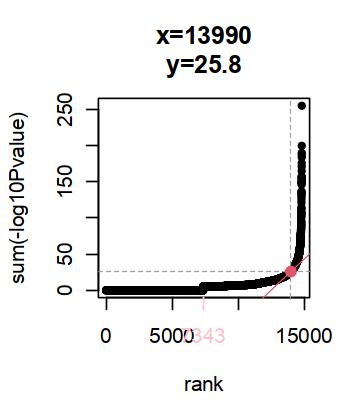

$absolute
[1] 32.36359

$overMedian
[1] 4.542878

$overMean
[1] 2.60768

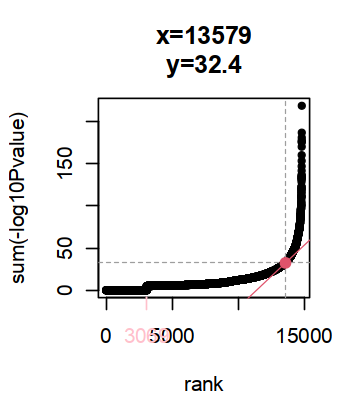

In [26]:
options(repr.plot.width=3,repr.plot.height=3.5)
calculate_cutoff(RG_eN_SIO %>% arrange(sumFDR.y)%>% .$sumFDR.y)
calculate_cutoff(RG_eN_SIO %>% arrange(sumFDR.x)%>% .$sumFDR.x)

In [27]:
RGSIO <- RG_eN_SIO %>% filter(sumFDR.x >= 32.3635894409003) %>% mutate(ID=paste(c,s,e,sep="-")) 
eNSIO <- RG_eN_SIO %>% filter(sumFDR.y >= 25.8068011915805)%>% mutate(ID=paste(c,s,e,sep="-"))

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


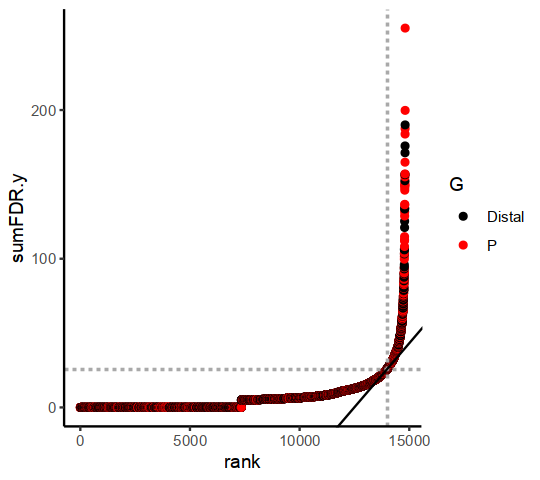

In [28]:
options(repr.plot.width=4.5,repr.plot.height=4)
input <- RG_eN_SIO %>% arrange(sumFDR.y)
input$rank <- 1:dim(input)[1]
data <- input$sumFDR.y
slope <- (max(data)-min(data))/length(data) #This is the slope of the line we want to slide. This is the diagonal.
xPt <- floor(optimize(numPts_below_line,lower=1,upper=length(data),myVector= data,slope=slope)$minimum) #Find the x-axis point where a line passing through that point has the minimum number of points below it. (ie. tangent)
y_cutoff <- data[xPt] #The y-value at this x point. This is our cutoff.
b <- y_cutoff-(slope* xPt)
ggplot(input, aes(x=rank,y=sumFDR.y,colour=G)) + 
geom_point() + 
scale_colour_manual(values=c("P"="red1","Distal"="black")) + 
geom_hline(aes(yintercept=y_cutoff),linetype="dashed",color="darkgray",size=0.75) + 
geom_vline(aes(xintercept=xPt),linetype="dashed",color="darkgray",size=0.75) +
geom_abline(intercept = b,slope = slope,color="black",size=0.5) +
theme_classic() #398

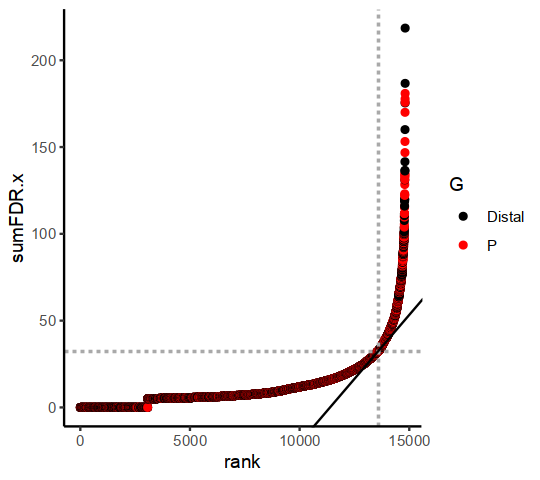

In [29]:
input <- RG_eN_SIO %>% arrange(sumFDR.x)
input$rank <- 1:dim(input)[1]
data <- input$sumFDR.x
slope <- (max(data)-min(data))/length(data) #This is the slope of the line we want to slide. This is the diagonal.
xPt <- floor(optimize(numPts_below_line,lower=1,upper=length(data),myVector= data,slope=slope)$minimum) #Find the x-axis point where a line passing through that point has the minimum number of points below it. (ie. tangent)
y_cutoff <- data[xPt] #The y-value at this x point. This is our cutoff.
b <- y_cutoff-(slope* xPt)
ggplot(input, aes(x=rank,y=sumFDR.x,colour=G)) + 
geom_point() + 
scale_colour_manual(values=c("P"="red1","Distal"="black")) + 
geom_hline(aes(yintercept=y_cutoff),linetype="dashed",color="darkgray",size=0.75) + 
geom_vline(aes(xintercept=xPt),linetype="dashed",color="darkgray",size=0.75) +
geom_abline(intercept = b,slope = slope,color="black",size=0.5) +
theme_classic() #398

$absolute
[1] 37.80234

$overMedian
[1] 4.732289

$overMean
[1] 2.777312

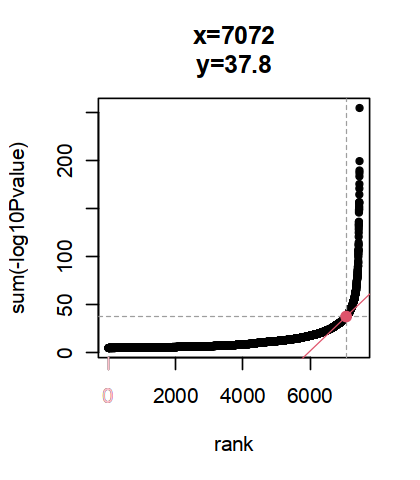

In [30]:
options(repr.plot.width=3.5,repr.plot.height=4)
calculate_cutoff(eN.io$sumFDR)

# diff loops

In [33]:
setwd("/lustre/user/liclab/jialm/Project/SCOPEC/analysis/fithicLoop/RG_eN/")

In [34]:
file.ls <- list.files("./",pattern="sta$")

In [35]:
sta <- lapply(file.ls,read.table)

In [36]:
inpt <- dplyr::full_join(sta[[2]],sta[[4]],by=c("V1","V2","V3","V4","V5","V6")) %>%
dplyr::full_join(sta[[1]],by=c("V1","V2","V3","V4","V5","V6")) %>%
dplyr::full_join(sta[[3]],by=c("V1","V2","V3","V4","V5","V6")) %>%
replace(is.na(.),0)

In [37]:
data <- inpt[,-(1:6)] 
group <- c(rep("RG",2),rep("eN",2))
genes <- inpt[,1:6]
dge <- DGEList(counts = data, genes = genes, group = group)
#keep <- filterByExpr(dge, group = group)
dge <- calcNormFactors(dge)
#dge <- dge[keep,]
dge <- estimateDisp(dge)
design <- model.matrix(~ 0 + group, data = dge$samples)
fit <- glmQLFit(dge, design = design)
AvsB <- makeContrasts(groupeN-groupRG, levels=design)
qlf <- glmQLFTest(fit, contrast= AvsB)

Using classic mode.



In [38]:
RGtoeN <- topTags(qlf, n = Inf)$table %>% mutate(Group=case_when(logFC >=0.5 & FDR<=0.05~"Up",
                                                       logFC <= -0.5 & FDR<=0.05~"Down",
                                                        abs(logFC) <0.5 | FDR>0.05~"Not"))
RGtoeN %>% group_by(Group) %>% summarise(n=n())

Group,n
<chr>,<int>
Down,177
Not,14159
Up,380


In [39]:
eNUp <- RGtoeN %>%filter(Group=="Up") %>% select(V1,V2,V3,V4,V5,V6,FDR,Group) 
eNDown <- RGtoeN %>%filter(Group=="Down") %>% select(V1,V2,V3,V4,V5,V6,FDR,Group) 
eNNot <- RGtoeN %>%filter(Group=="Not") %>% select(V1,V2,V3,V4,V5,V6,FDR,Group) 

In [40]:
eN.enrich.SIO.score <- rbind(RGtoeN[,c(1:3,11,12)] %>% set_names("V1","V2","V3","FDR","Group"),
      RGtoeN[,c(4:6,11,12)] %>% set_names("V1","V2","V3","FDR","Group")) %>%
mutate(logFDR=-log10(FDR))%>%
group_by(V1,V2,V3,Group) %>%
summarise(score=sum(logFDR)) %>%
tidyr::pivot_wider(id_cols = V1:V3, names_from = 'Group', values_from = "score")%>%
replace(is.na(.),0) %>%
mutate(enrich=Up-Down-Not) %>%
arrange(enrich) %>% 
filter(enrich >=0) %>% .$enrich 

`summarise()` has grouped output by 'V1', 'V2', 'V3'. You can override using the `.groups` argument.


In [41]:
RG.enrich.SIO.score <- rbind(RGtoeN[,c(1:3,11,12)] %>% set_names("V1","V2","V3","FDR","Group"),
      RGtoeN[,c(4:6,11,12)] %>% set_names("V1","V2","V3","FDR","Group")) %>%
mutate(logFDR=-log10(FDR))%>%
group_by(V1,V2,V3,Group) %>%
summarise(score=sum(logFDR)) %>%
tidyr::pivot_wider(id_cols = V1:V3, names_from = 'Group', values_from = "score")%>%
replace(is.na(.),0) %>%
mutate(enrich=Down-Up-Not) %>%
arrange(enrich) %>% 
filter(enrich >=0) %>% .$enrich 

`summarise()` has grouped output by 'V1', 'V2', 'V3'. You can override using the `.groups` argument.


In [42]:
eN.IO.overRG <- rbind(RGtoeN[,c(1:3,11,12)] %>% set_names("V1","V2","V3","FDR","Group"),
      RGtoeN[,c(4:6,11,12)] %>% set_names("V1","V2","V3","FDR","Group"))%>%
mutate(logFDR=-log10(FDR))%>%
group_by(V1,V2,V3,Group) %>%
summarise(score=sum(logFDR))%>%
tidyr::pivot_wider(id_cols = V1:V3, names_from = 'Group', values_from = "score")%>%
replace(is.na(.),0) %>%
mutate(enrich=Up-Down-Not) %>%
filter(enrich >=0) %>%
arrange(enrich)

quantile(eN.enrich.SIO.score,.8)

eN.SIO.overRG <- rbind(RGtoeN[,c(1:3,11,12)] %>% set_names("V1","V2","V3","FDR","Group"),
      RGtoeN[,c(4:6,11,12)] %>% set_names("V1","V2","V3","FDR","Group"))%>%
mutate(logFDR=-log10(FDR))%>%
group_by(V1,V2,V3,Group) %>%
summarise(score=sum(logFDR))%>%
tidyr::pivot_wider(id_cols = V1:V3, names_from = 'Group', values_from = "score")%>%
replace(is.na(.),0) %>%
mutate(enrich=Up-Down-Not) %>%
arrange(desc(enrich)) %>%
filter(enrich >=2.4967581763044) 

`summarise()` has grouped output by 'V1', 'V2', 'V3'. You can override using the `.groups` argument.


80% 
2.496758

`summarise()` has grouped output by 'V1', 'V2', 'V3'. You can override using the `.groups` argument.


In [43]:
quantile(eN.enrich.SIO.score,.8)
quantile(RG.enrich.SIO.score,.8)

80% 
2.496758

80% 
1.79179

In [44]:
RG.IO.overeN <- rbind(RGtoeN[,c(1:3,11,12)] %>% set_names("V1","V2","V3","FDR","Group"),
      RGtoeN[,c(4:6,11,12)] %>% set_names("V1","V2","V3","FDR","Group"))%>%
mutate(logFDR=-log10(FDR))%>%
group_by(V1,V2,V3,Group) %>%
summarise(score=sum(logFDR))%>%
tidyr::pivot_wider(id_cols = V1:V3, names_from = 'Group', values_from = "score")%>%
replace(is.na(.),0) %>%
mutate(enrich=Down-Up-Not) %>%
filter(enrich >=0) %>%
arrange(enrich)

RG.SIO.overeN <- rbind(RGtoeN[,c(1:3,11,12)] %>% set_names("V1","V2","V3","FDR","Group"),
      RGtoeN[,c(4:6,11,12)] %>% set_names("V1","V2","V3","FDR","Group"))%>%
mutate(logFDR=-log10(FDR))%>%
group_by(V1,V2,V3,Group) %>%
summarise(score=sum(logFDR))%>%
tidyr::pivot_wider(id_cols = V1:V3, names_from = 'Group', values_from = "score")%>%
replace(is.na(.),0) %>%
mutate(enrich=Down-Up-Not) %>%
arrange(desc(enrich)) %>%
filter(enrich >=1.79179035132566) 

`summarise()` has grouped output by 'V1', 'V2', 'V3'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'V1', 'V2', 'V3'. You can override using the `.groups` argument.


In [369]:
write.table(eN.SIO.overRG,"./eN.SIO.overRG.bed",col.names = F,row.names = F,sep="\t",quote=F)
write.table(RG.SIO.overeN,"./RG.SIO.overeN.bed",col.names = F,row.names = F,sep="\t",quote=F)

In [45]:
RNA <- read.table("../sc_human_average_CPM.txt") %>% filter(RG>0.5 | IPC >0.5 | eN >0.5 | iN >0.5)
RNA$symbol <- rownames(RNA)

In [46]:
eN.res <- read.table("./eN.SIO.overRG.gene.final.res")
eN.RNA <- eN.res %>% group_by(V1,V2,V3,V4,V5,V6,V7,V8) %>% 
summarise(V9=min(V9)) %>% 
dplyr::right_join(eN.SIO.overRG) %>%
dplyr::inner_join(RNA,by=c("V8"="symbol")) %>% 
as.data.frame() %>%
mutate(logRG=log2(RG+1),logeN=log2(eN+1)) %>%
select(V1,V2,V3,enrich,V8,logRG,logeN) %>% 
arrange(desc(enrich))
eN.IO.plotDF <-eN.RNA %>%
arrange(desc(enrich))%>% distinct() %>%group_by(V1,V2,V3,enrich) %>%
    dplyr::summarise(symbols = paste(V8, collapse = ",")) %>% 
dplyr::right_join(eN.IO.overRG) %>%
arrange(enrich)
eN.IO.plotDF$rank=1:dim(eN.IO.plotDF)[1]

eN.IO.plotDF.gr <- makeGRangesFromDataFrame(eN.IO.plotDF,seqnames.field = "V1",
                                            start.field = "V2",end.field = "V3",keep.extra.columns = T)

PH <- queryHits(findOverlaps(eN.IO.plotDF.gr,promoter.gr)) %>% unique()

eN.IO.plotDF <- eN.IO.plotDF %>% mutate(type=case_when(rank %in% PH ~ "promoter",
                                  !rank %in% PH ~ "distal"))

`summarise()` has grouped output by 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7'. You can override using the `.groups`
argument.
Joining with `by = join_by(V1, V2, V3)`
`summarise()` has grouped output by 'V1', 'V2', 'V3'. You can override using the `.groups` argument.
Joining with `by = join_by(V1, V2, V3, enrich)`


In [47]:
RG.res <- read.table("./RG.SIO.overeN.gene.final.res")
RG.RNA <- RG.res %>% group_by(V1,V2,V3,V4,V5,V6,V7,V8) %>% 
summarise(V9=min(V9)) %>% 
dplyr::right_join(RG.SIO.overeN) %>%
dplyr::inner_join(RNA,by=c("V8"="symbol")) %>% 
as.data.frame() %>%
mutate(logRG=log2(RG+1),logeN=log2(eN+1)) %>%
select(V1,V2,V3,enrich,V8,logRG,logeN) %>% 
arrange(desc(enrich))

RG.IO.plotDF <-RG.RNA %>%
arrange(desc(enrich))%>% distinct() %>%group_by(V1,V2,V3,enrich) %>%
    dplyr::summarise(symbols = paste(V8, collapse = ",")) %>% 
dplyr::right_join(RG.IO.overeN) %>%
arrange(enrich)

RG.IO.plotDF$rank=1:dim(RG.IO.plotDF)[1]

RG.IO.plotDF.gr <- makeGRangesFromDataFrame(RG.IO.plotDF,seqnames.field = "V1",
                                            start.field = "V2",end.field = "V3",keep.extra.columns = T)

PH <- queryHits(findOverlaps(RG.IO.plotDF.gr,promoter.gr)) %>% unique()

RG.IO.plotDF <- RG.IO.plotDF %>% mutate(type=case_when(rank %in% PH ~ "promoter",
                                  !rank %in% PH ~ "distal"))

`summarise()` has grouped output by 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7'. You can override using the `.groups`
argument.
Joining with `by = join_by(V1, V2, V3)`
`summarise()` has grouped output by 'V1', 'V2', 'V3'. You can override using the `.groups` argument.
Joining with `by = join_by(V1, V2, V3, enrich)`


Warning message:
“Removed 1 rows containing missing values (`geom_text_repel()`).”


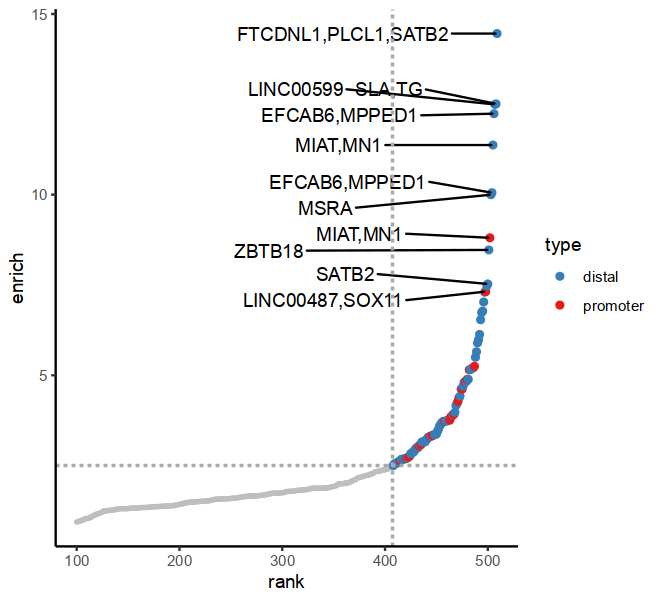

In [48]:
options(repr.plot.width=5.5,repr.plot.height=5)
input <- eN.IO.plotDF %>% arrange(enrich)
input$rank <- 1:dim(input)[1]
data <- input$enrich
slope <- (max(data)-min(data))/length(data) #This is the slope of the line we want to slide. This is the diagonal.
xPt <- 407#floor(optimize(numPts_below_line,lower=1,upper=length(data),myVector= data,slope=slope)$minimum) #Find the x-axis point where a line passing through that point has the minimum number of points below it. (ie. tangent)
y_cutoff <- 2.4967581763044#data[xPt] #The y-value at this x point. This is our cutoff.
b <- y_cutoff-(slope* xPt)
ggplot(input%>%filter(rank>=100), aes(x=rank,y=enrich)) + 
geom_point(color="gray",size=.5) + 
geom_point(data = input[input$enrich >=2.4967581763044,], aes(color = type) ) +
ggrepel::geom_text_repel(data = tail(input,12), aes(label = symbols), nudge_y = -0, nudge_x = -150 ) +
scale_color_brewer(palette = "Set1", direction = -1) +
geom_hline(aes(yintercept=y_cutoff),linetype="dashed",color="darkgray",size=0.75) + 
geom_vline(aes(xintercept=xPt),linetype="dashed",color="darkgray",size=0.75) +
#ylim(-15,0)+
#geom_abline(intercept = b,slope = slope,color="black",size=0.5) +
theme_classic() 
#ggsave("../../FINAL_figures/huamnBrain.1k.eNoverRG.SIO.geompoint.pdf",width=4,height=3.6)

Warning message:
“Removed 1 rows containing missing values (`geom_text_repel()`).”


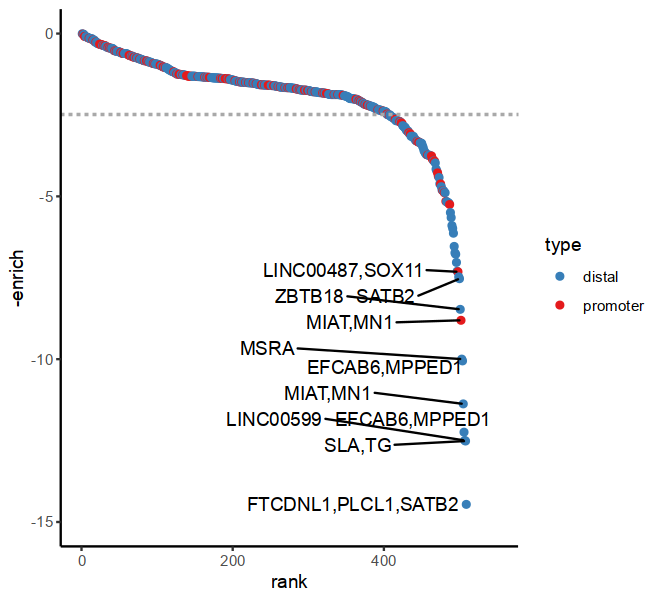

In [49]:
options(repr.plot.width=5.5,repr.plot.height=5)
input <- eN.IO.plotDF %>% arrange(enrich)
input$rank <- 1:dim(input)[1]
data <- input$enrich
slope <- (max(data)-min(data))/length(data) #This is the slope of the line we want to slide. This is the diagonal.
xPt <- 407#floor(optimize(numPts_below_line,lower=1,upper=length(data),myVector= data,slope=slope)$minimum) #Find the x-axis point where a line passing through that point has the minimum number of points below it. (ie. tangent)
y_cutoff <- 2.4967581763044#data[xPt] #The y-value at this x point. This is our cutoff.
b <- y_cutoff-(slope* xPt)
ggplot(input%>%filter(rank>=100), aes(x=rank,y=-enrich)) + 
geom_point(color="gray",size=.5) + 
geom_point(data = input, aes(color = type) ) +
ggrepel::geom_text_repel(data = tail(input,12), aes(label = symbols), nudge_y = -0, nudge_x = -150 ) +
scale_color_brewer(palette = "Set1", direction = -1) +
geom_hline(aes(yintercept=-y_cutoff),linetype="dashed",color="darkgray",size=0.75) + 
#geom_vline(aes(xintercept=xPt),linetype="dashed",color="darkgray",size=0.75) +
ylim(-15,0)+
xlim(0,550)+
#geom_abline(intercept = b,slope = slope,color="black",size=0.5) +
theme_classic() 
#ggsave("../../../FINAL_figures/huamnBrain.1k.eNoverRG.SIO.geompoint.NEW.pdf",width=4,height=3.6)

Warning message:
“Removed 1 rows containing missing values (`geom_text_repel()`).”


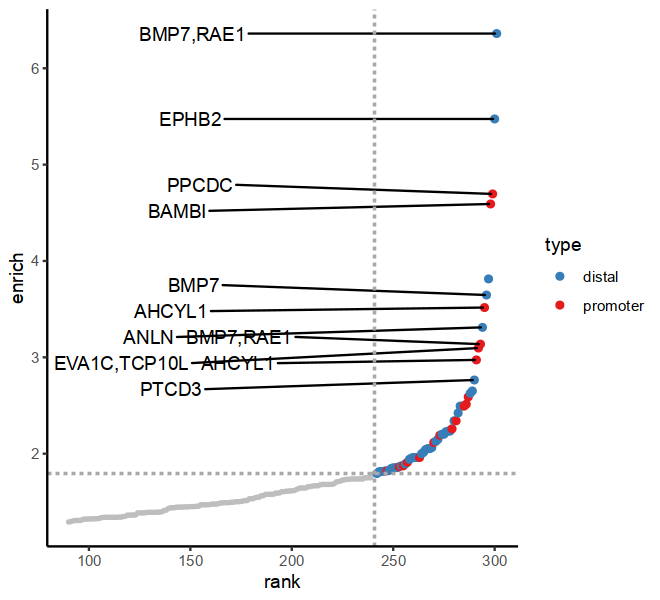

In [50]:
options(repr.plot.width=5.5,repr.plot.height=5)
input <- RG.IO.plotDF %>% arrange(enrich)
input$rank <- 1:dim(input)[1]
data <- input$enrich
slope <- (max(data)-min(data))/length(data) #This is the slope of the line we want to slide. This is the diagonal.
xPt <- 241#floor(optimize(numPts_below_line,lower=1,upper=length(data),myVector= data,slope=slope)$minimum) #Find the x-axis point where a line passing through that point has the minimum number of points below it. (ie. tangent)
y_cutoff <- 1.79179035132566#data[xPt] #The y-value at this x point. This is our cutoff.
b <- y_cutoff-(slope* xPt)
ggplot(input%>%filter(rank>=90), aes(x=rank,y=enrich)) + 
geom_point(color="gray",size=.5) + 
geom_point(data = input[input$enrich >=1.79179035132566,], aes(color = type) ) +
ggrepel::geom_text_repel(data = tail(input,12), aes(label = symbols), nudge_y = -0, nudge_x = -150 ) +
scale_color_brewer(palette = "Set1", direction = -1) +
geom_hline(aes(yintercept=y_cutoff),linetype="dashed",color="darkgray",size=0.75) + 
geom_vline(aes(xintercept=xPt),linetype="dashed",color="darkgray",size=0.75) +
#ylim(0,7)+
#geom_abline(intercept = b,slope = slope,color="black",size=0.5) +
theme_classic() 
#ggsave("../../FINAL_figures/huamnBrain.1k.RGovereN.SIO.geompoint.pdf",width=4,height=3.6)

Warning message:
“Removed 1 rows containing missing values (`geom_text_repel()`).”


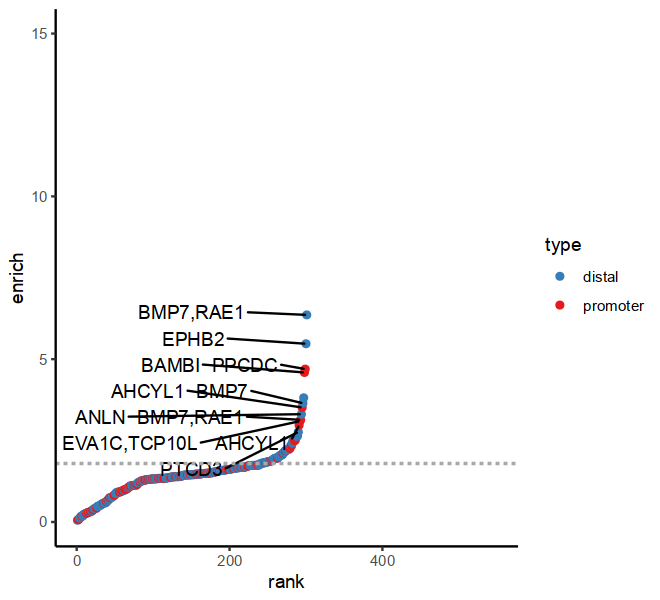

In [51]:
options(repr.plot.width=5.5,repr.plot.height=5)
input <- RG.IO.plotDF %>% arrange(enrich)
input$rank <- 1:dim(input)[1]
data <- input$enrich
slope <- (max(data)-min(data))/length(data) #This is the slope of the line we want to slide. This is the diagonal.
xPt <- 241#floor(optimize(numPts_below_line,lower=1,upper=length(data),myVector= data,slope=slope)$minimum) #Find the x-axis point where a line passing through that point has the minimum number of points below it. (ie. tangent)
y_cutoff <- 1.79179035132566#data[xPt] #The y-value at this x point. This is our cutoff.
b <- y_cutoff-(slope* xPt)
ggplot(input%>%filter(rank>=90), aes(x=rank,y=enrich)) + 
geom_point(color="gray",size=.5) + 
geom_point(data = input, aes(color = type) ) +
ggrepel::geom_text_repel(data = tail(input,12), aes(label = symbols), nudge_y = -0, nudge_x = -150 ) +
scale_color_brewer(palette = "Set1", direction = -1) +
geom_hline(aes(yintercept=y_cutoff),linetype="dashed",color="darkgray",size=0.75) + 
#geom_vline(aes(xintercept=xPt),linetype="dashed",color="darkgray",size=0.75) +
ylim(0,15)+
xlim(0,550)+
#geom_abline(intercept = b,slope = slope,color="black",size=0.5) +
theme_classic() 
#ggsave("../../../FINAL_figures/huamnBrain.1k.RGovereN.SIO.geompoint.NEW.pdf",width=4,height=3.6)

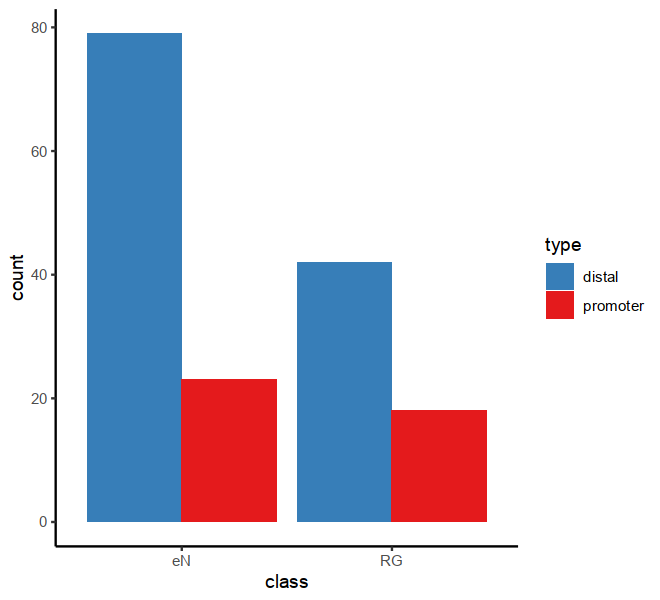

In [52]:
rbind(RG.IO.plotDF %>% arrange(enrich) %>% filter(enrich >= 1.79179035132566) %>%
mutate(class="RG") %>% select(V1,V2,V3,type,class) %>% distinct(),
eN.IO.plotDF %>% arrange(enrich) %>% filter(enrich >= 2.4967581763044) %>%
mutate(class="eN")%>% select(V1,V2,V3,type,class) %>% distinct()) %>%
#group_by(type,class)%>%
#summarise(n=n())%>%
ggplot(aes(class))+
geom_bar(aes(fill = type),position = position_dodge())+
scale_fill_brewer(palette = "Set1", direction = -1) +
theme_classic()
#ggsave("../../FINAL_figures/huamnBrain.1k.RG_eN_overbetween.SIO.PE.sta.barplot.pdf",width=4,height=3.6)

In [53]:
rbind(RG.IO.plotDF %>% arrange(enrich) %>% filter(enrich >= 1.79179035132566) %>%
mutate(class="RG") %>% select(V1,V2,V3,type,class) %>% distinct(),
eN.IO.plotDF %>% arrange(enrich) %>% filter(enrich >= 2.4967581763044) %>%
mutate(class="eN")%>% select(V1,V2,V3,type,class) %>% distinct()) %>% 
group_by(type,class) %>%
summarise(n=n())

`summarise()` has grouped output by 'type'. You can override using the `.groups` argument.


type,class,n
<chr>,<chr>,<int>
distal,RG,42
distal,eN,79
promoter,RG,18
promoter,eN,23


In [54]:
chiDF <- matrix(c(18,42,23,79),2,2,dimnames=list(class=c("promoter","distal"),celltype=c("RG","eN")))

In [55]:
chisq.test(chiDF,correct = T)


	Pearson's Chi-squared test with Yates' continuity correction

data:  chiDF
X-squared = 0.75034, df = 1, p-value = 0.3864


In [56]:
RG.eN.RNA <- rbind(eN.RNA %>% mutate(SIO="in_eN"),
RG.RNA %>% mutate(SIO="in_RG",enrich=-enrich)) %>%
arrange(desc(enrich))

In [57]:
library(ggforce)

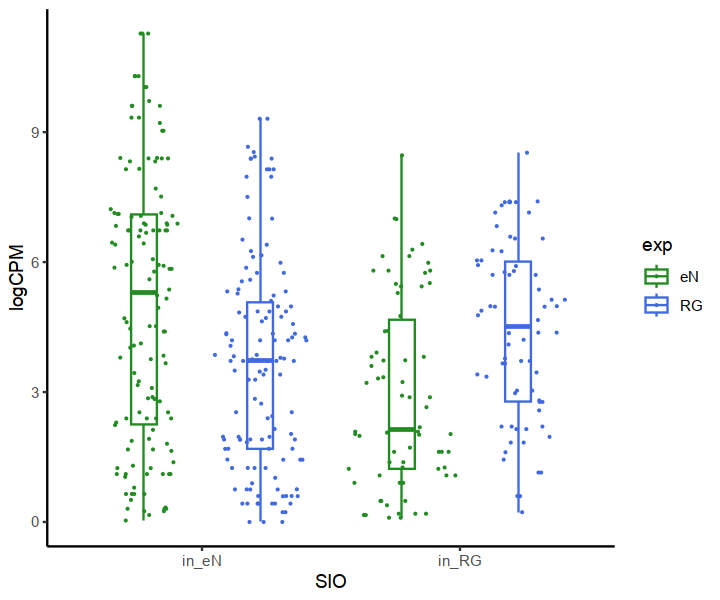

In [58]:
options(repr.plot.width=6,repr.plot.height=5)
RG.eN.RNAplotDF <- rbind(RG.eN.RNA[,c(1:3,5,6,8)] %>% 
      set_names("seq","start","end","symbol","logCPM","SIO")%>%
      mutate(exp="RG"),
      RG.eN.RNA[,c(1:3,5,7,8)] %>% 
      set_names("seq","start","end","symbol","logCPM","SIO")%>%
      mutate(exp="eN"))

ggplot(data = RG.eN.RNAplotDF, aes(x = SIO, y = logCPM, color = exp)) +
  #geom_violin()+
  geom_boxplot(width=0.2,
               position = position_dodge(.9))+
  scale_color_manual(values = c("forestgreen","royalblue"))+
#geom_jitter(size=.1)+
geom_sina(size=0.1,alpha=1)+
  theme_classic()
#ggsave("../../FINAL_figures/huamnBrain.1k.RG_eN_overbetween.SIO.PE.RNA.boxplot.pdf",width=4,height=3.6)

In [73]:
eN.dSIO.gene <- RG.eN.RNAplotDF %>% filter(SIO=="in_eN") %>% select(symbol) %>% distinct()

In [76]:
write.table(eN.dSIO.gene,"./human_eN_dSIO.gene.txt",col.names = F,row.names = F,sep="\t",quote=F)

In [75]:
getwd()

[1] "/lustre/user/liclab/jialm/Project/SCOPEC/analysis/fithicLoop/RG_eN"

In [58]:
wilcox.test(RG.eN.RNA %>% filter(SIO=="in_eN") %>% .$logRG,
           RG.eN.RNA %>% filter(SIO=="in_eN") %>% .$logeN,alternative = "less")


	Wilcoxon rank sum test with continuity correction

data:  RG.eN.RNA %>% filter(SIO == "in_eN") %>% .$logRG and RG.eN.RNA %>% filter(SIO == "in_eN") %>% .$logeN
W = 6309, p-value = 0.0002072
alternative hypothesis: true location shift is less than 0


In [59]:
wilcox.test(RG.eN.RNA %>% filter(SIO=="in_RG") %>% .$logRG,
           RG.eN.RNA %>% filter(SIO=="in_RG") %>% .$logeN,alternative = "greater")


	Wilcoxon rank sum test with continuity correction

data:  RG.eN.RNA %>% filter(SIO == "in_RG") %>% .$logRG and RG.eN.RNA %>% filter(SIO == "in_RG") %>% .$logeN
W = 3408, p-value = 3.293e-05
alternative hypothesis: true location shift is greater than 0


Warning message:
“`breaks` does not have the same length as `color`. The colors are
interpolated from the minimal to the maximal of `breaks`.”


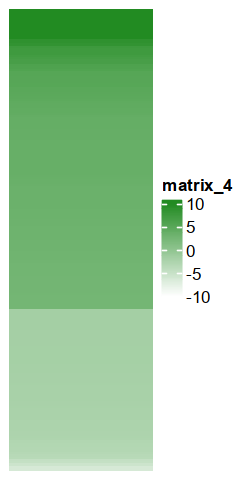

In [64]:
options(repr.plot.width=2,repr.plot.height=4)
#pdf("../../FINAL_figures/huamnBrain.1k.RG_eN_overbetween.SIO.PE.RNA.heatmap_1.pdf",width=2,height=4)
pheatmap(as.matrix(RG.eN.RNA[,4]),cluster_rows=F,breaks=c(-10,10),
         col=colorRampPalette(c("white","forestgreen"))(500))
#dev.off()

Warning message:
“`breaks` does not have the same length as `color`. The colors are
interpolated from the minimal to the maximal of `breaks`.”


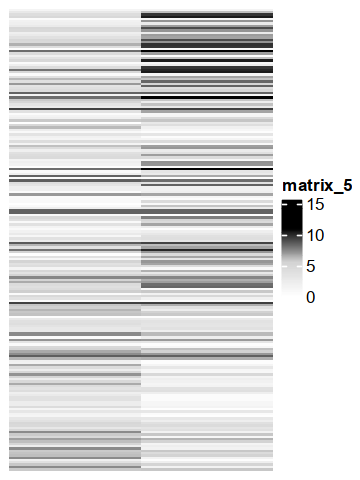

In [65]:
options(repr.plot.width=3,repr.plot.height=4)
#pdf("../../FINAL_figures/huamnBrain.1k.RG_eN_overbetween.SIO.PE.RNA.heatmap_2.pdf",width=2.8,height=4)
pheatmap(as.matrix(RG.eN.RNA[,c(6,7)]),cluster_rows=F,cluster_cols = F,breaks=c(0,11),show_colnames = F,
         col=colorRampPalette(c("white","lightgray","black"))(500))
#dev.off()

# PLACseq

In [66]:
setwd("/lustre/user/liclab/jialm/Project/SCOPEC/publicdata/human-shenyin-PLACseq")

In [67]:
FL <- list.files("./",pattern="hg19$") %>% lapply(.,read.table)

In [68]:
list.files("./",pattern="hg19$")

[1] "eN.MAPS.peaks.hg19"  "iN.MAPS.peaks.hg19"  "iPC.MAPS.peaks.hg19"
[4] "RG.MAPS.peaks.hg19"

In [ ]:
eN <- dplyr::inner_join(FL[[1]],FL[[2]],by="V4") %>% filter(V3.y > V3.x,V5.x==1,V5.y==1)
iN <- dplyr::inner_join(FL[[3]],FL[[4]],by="V4") %>% filter(V3.y > V3.x,V5.x==1,V5.y==1)
iPC <- dplyr::inner_join(FL[[5]],FL[[6]],by="V4") %>% filter(V3.y > V3.x,V5.x==1,V5.y==1)
RG <- dplyr::inner_join(FL[[7]],FL[[8]],by="V4") %>% filter(V3.y > V3.x,V5.x==1,V5.y==1)

In [ ]:
eN %>% head()

In [ ]:
write.table(RG[,c(1:3,6:8,4)],"./RG.MAPS.peaks.hg19",col.names = F,row.names = F,sep="\t",quote=F)
write.table(iPC[,c(1:3,6:8,4)],"./iPC.MAPS.peaks.hg19",col.names = F,row.names = F,sep="\t",quote=F)
write.table(eN[,c(1:3,6:8,4)],"./eN.MAPS.peaks.hg19",col.names = F,row.names = F,sep="\t",quote=F)
write.table(iN[,c(1:3,6:8,4)],"./iN.MAPS.peaks.hg19",col.names = F,row.names = F,sep="\t",quote=F)

# motifs

In [5]:
setwd("/lustre/user/liclab/jialm/Project/SCOPEC/analysis/fithicLoop/RG_eN/")

In [16]:
RG.motif <- read.delim("./RG.SIO.overeN.loops.ATACpeaks.default.motif/knownResults.txt") %>%
set_names(c("motif","consensus","p.value","dis","FDR","counts","ratio","bg.counts","bg.ratio")) %>%
mutate(cell="RG",logP=-log10(p.value))
eN.motif <- read.delim("./eN.SIO.overRG.loops.ATACpeaks.default.motif/knownResults.txt") %>%
set_names(c("motif","consensus","p.value","dis","FDR","counts","ratio","bg.counts","bg.ratio")) %>%
mutate(cell="eN",logP=-log10(p.value))

In [45]:
motif.res <- dplyr::full_join(RG.motif[,c(1,2,6,7,11,10)],
                 eN.motif[,c(1,2,6,7,11,10)],by=c("motif")) %>% 
filter(logP.x >3 | logP.y >3) %>%
mutate(symbol=gsub("\\/.*","",.$motif),
       ID=gsub("\\(.*","",.$motif)) %>% 
mutate(ID=gsub("\\-.*","",.$ID)) %>% 
filter(symbol!="SeqBias: A") %>%
mutate(ID=toupper(.$ID))

Warning message in dplyr::full_join(RG.motif[, c(1, 2, 6, 7, 11, 10)], eN.motif[, :
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 875 of `x` matches multiple rows in `y`.
ℹ Row 809 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”


In [39]:
RNA <- read.table("../sc_human_average_CPM.txt") %>% filter(RG>0.5 | IPC >0.5 | eN >0.5 | iN >0.5)
RNA$symbol <- rownames(RNA)

In [98]:
motif.RNA <- dplyr::inner_join(motif.res,RNA,by=c("ID"="symbol")) %>% 
mutate(logRG=log2(RG+1),logeN=log2(eN+1))

In [99]:
rank <- motif.RNA$symbol[c(7,12,11,9,8,10,4,2,3,5,6,1)]

In [100]:
plotDF <- rbind(motif.RNA[,c(12,4,5,6,18)] %>% 
set_names("motif","ratio","logP","cell","log2RPKM"),
     motif.RNA[,c(12,9,10,11,19)] %>% 
set_names("motif","ratio","logP","cell","log2RPKM"))

In [101]:
plotDF$motif <- factor(plotDF$motif,levels=rank)
plotDF$cell <- factor(plotDF$cell,levels=c("RG","eN"))

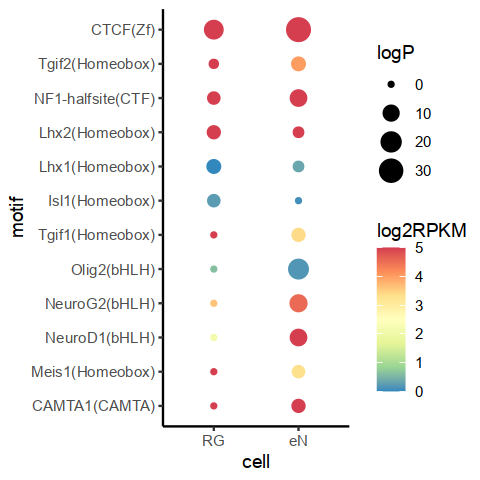

In [122]:
options(repr.plot.width=4,repr.plot.height=4)
ggplot(plotDF, aes(cell, motif)) +
geom_point(aes(color=log2RPKM, size=logP)) +
#scale_color_gradientn(colours=c("blue","white","red")) +
scale_color_distiller(palette = "Spectral")+
theme_classic()
ggsave("../../../FINAL_figures/RG_eN_SIO_motif.and.EXP.pdf",height = 4,width=4)